In [1]:
import os
base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data'
os.chdir(base_dir) 
from core import expression_plots 
from core import io_library 
#from IPython.core.debugger import Tracer
import numpy as np
import pandas as pd
from collections import Counter #, defaultdict
#import re
#import matplotlib.pyplot as plt 
#import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [24]:
#Load various SC NMPP1 experiment data

#load raw data for NMPP1 experiments from Capaldi Paper
desired_conditions = [('100uM NMPP1','GSM1423542')]
data_dir = base_dir + '\expression_data\GSE58992_Capaldi_2014\\'
GEO_accession = 'GSE58992'
capaldi_SC_PKA_data = io_library.parse_data_series_matrix_SC(desired_conditions, data_dir, GEO_accession)

#Load PKA inhibition data for O'shea
oshea_SC_PKA_data = io_library.load_oshea_NMPP1_data()
# desired_conditions = [('No 1-NMPP1 0 min','GSM812516'), ('3uM 1-NMPP1 40 min','GSM812520')]   
# data_dir = base_dir + '\expression_data\GSE32703_NMPP1_SC\\' 
# GEO_accession = 'GSE32703'
# oshea_SC_PKA_data = io_library.parse_data_series_matrix_SC(desired_conditions, data_dir, GEO_accession)
# oshea_SC_PKA_data['PKA inhibition 3uM 1NMPP1'] = oshea_SC_PKA_data.iloc[:,1].sub(oshea_SC_PKA_data.iloc[:,0])

#Load Kieran's PKA inhibition data
fname_mace_SC_PKA_data = os.path.normpath(base_dir + '\expression_data\SCer_NMPP1_RNA_Seq\SC_1NMPP1_From_Kieran.tsv')
mace_SC_PKA_data = pd.read_table(fname_mace_SC_PKA_data, sep = ' ', index_col = [0])
mace_SC_PKA_data.columns = ['WT_minus','AS_plus','WT_plus']

#Normalize by the total number of reads
mace_SC_PKA_data_total_reads = mace_SC_PKA_data.sum(axis = 'rows')
mace_SC_PKA_data_norm = pd.DataFrame(index = mace_SC_PKA_data.index)
#normalize by total aligned reads, adding in a single pseudocount to avoid dividing by zero
for sample in mace_SC_PKA_data.columns: 
    mace_SC_PKA_data_norm[sample] = (mace_SC_PKA_data[sample]+1)/mace_SC_PKA_data_total_reads[sample]

#Make Fold change columns
mace_SC_PKA_data_norm['WT_log_fold_change']=np.log(mace_SC_PKA_data_norm['WT_plus']/mace_SC_PKA_data_norm['WT_minus'])/np.log(2.0)
mace_SC_PKA_data_norm['AS_plus_WT_minus_log_fold_change'] = np.log(mace_SC_PKA_data_norm['AS_plus']/mace_SC_PKA_data_norm['WT_minus'])/np.log(2.0)

#Load Susan's TPK-AS NMPP1 data
fname_SYC_SC_PKA_plus = os.path.normpath(base_dir + '\expression_data\SCer_NMPP1_RNA_Seq_SYC\NMPP_abundance_paired.tsv')
SYC_SC_PKA_plus = pd.read_table(fname_SYC_SC_PKA_plus, sep = '\t', index_col = [0])
#SYC_SC_PKA_plus.columns are: ['length','eff_length','est_counts','TPM']
SYC_SC_PKA_plus_total_reads = SYC_SC_PKA_plus['est_counts'].sum(axis = 'rows')
SYC_SC_PKA_plus_norm = pd.DataFrame(index = SYC_SC_PKA_plus.index)
SYC_SC_PKA_plus_norm['AS_plus'] = (SYC_SC_PKA_plus['est_counts']+1)/SYC_SC_PKA_plus_total_reads


fname_SYC_SC_PKA_minus = os.path.normpath(base_dir + '\expression_data\SCer_NMPP1_RNA_Seq_SYC\\none_abundance_paired.tsv')
SYC_SC_PKA_minus = pd.read_table(fname_SYC_SC_PKA_minus, sep = '\t', index_col = [0])
#SYC_SC_PKA_minus.columns are: ['length','eff_length','est_counts','TPM']
SYC_SC_PKA_minus_total_reads = SYC_SC_PKA_minus['est_counts'].sum(axis = 'rows')
SYC_SC_PKA_minus_norm = pd.DataFrame(index = SYC_SC_PKA_minus.index)
SYC_SC_PKA_minus_norm['AS_minus'] = (SYC_SC_PKA_minus['est_counts']+1)/SYC_SC_PKA_minus_total_reads

SYC_SC_PKA_data_norm = pd.concat([SYC_SC_PKA_plus_norm, SYC_SC_PKA_minus_norm], axis = 1 )
SYC_SC_PKA_data_norm['AS_log_fold_change'] = np.log(SYC_SC_PKA_data_norm['AS_plus']/SYC_SC_PKA_data_norm['AS_minus'])/np.log(2.0)

#Load Solis 2016 PKA inhibition data
fname_solis_SC_PKA_data = os.path.normpath(base_dir + '\expression_data\SCer_NMPP1_RNA_Seq\solis_2016.xlsx')
solis_SC_all_data = pd.read_excel(fname_solis_SC_PKA_data, header = 3)

#The data set has a lot of duplicated indices - remove duplicates. 
#Make a dictionary by going down the list - this will leave in a bunch of NaNs for duplicates. 
solis_inhib_unique = {}
columns = ['Inhib','X466.1NM']
for item in solis_SC_all_data.iterrows():
    gene = item[1]['locus']
    exp_val = [item[1][column] for column in columns]
    solis_inhib_unique[gene] = exp_val

repeat_counter = Counter(solis_SC_all_data['locus'])
for gene in repeat_counter.keys():
     if repeat_counter[gene] > 1:
        dupe_rows = solis_SC_all_data[solis_SC_all_data['locus']==gene]
        solis_inhib_unique[gene] = [np.nanmean(dupe_rows[column]) for column in columns]

solis_SC = pd.DataFrame.from_dict(solis_inhib_unique, orient = 'index')
solis_SC.columns = columns




In [25]:
#Merge SCer PKA data
SC_PKA_data_norm = pd.concat([SYC_SC_PKA_data_norm['AS_log_fold_change'], mace_SC_PKA_data_norm['AS_plus_WT_minus_log_fold_change'],oshea_SC_PKA_data['SC_PKA(AS)+1NMPP1'], capaldi_SC_PKA_data['100uM NMPP1'],solis_SC[['Inhib','X466.1NM']]], axis = 1) #, solis_SC_all_data['Inhib']],axis = 1)
SC_PKA_data_norm.columns = ['Chen','Pincus','Oshea','Capaldi','Solis-HSAA','Solis-WT']

<IPython.core.display.Javascript object>


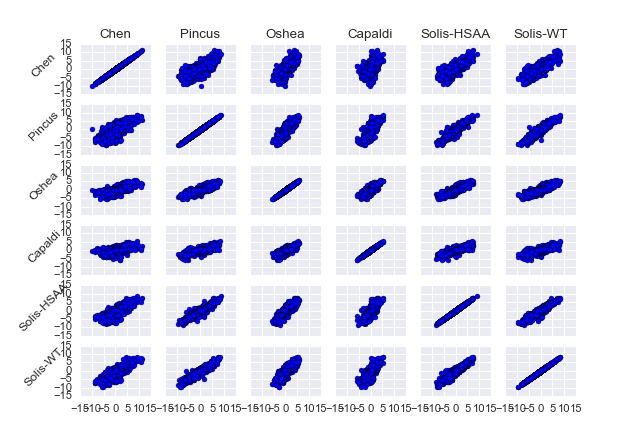

In [26]:
conditions = ['Chen','Pincus','Oshea','Capaldi','Solis-HSAA','Solis-WT']
fig, axarr = expression_plots.multi_scatter_plot(SC_PKA_data_norm, conditions)

Based on the above plot, the Pincus, and Solis datasets seem like better RNA-seq data than the Chen data dataset because they seem more correlated with Oshea and Capaldi.  

<IPython.core.display.Javascript object>


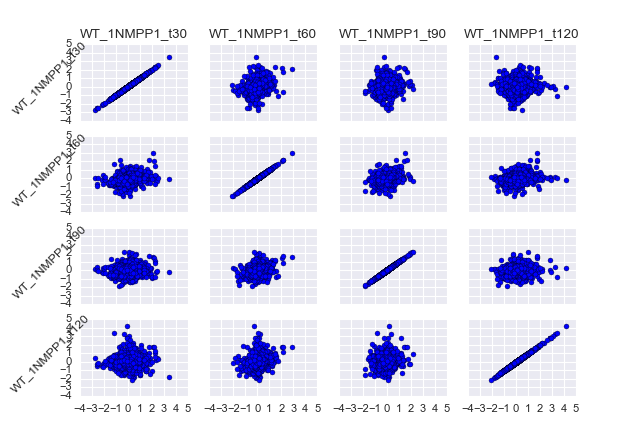

In [8]:
#Looking at NMPP1 only data from the shokat lab - the results weren't very illuminating - maybe that is a bad dataset. 

#Shokat Lab
fname_kung_SC_WT_NMPP1 = os.path.normpath(base_dir + '\expression_data\NMPP1_WT_Timecourse\\07170DataSet4.txt')
kung_SC_WT_NMPP1 = pd.read_table(fname_kung_SC_WT_NMPP1, sep = '\t', index_col = [0])
conditions_orig = kung_SC_WT_NMPP1.columns[1:]
conditions=  []
for condition in conditions_orig: 
    time = condition.split()[1]
    new_condition = 'WT_1NMPP1_t'+time
    conditions.append(new_condition)
    kung_SC_WT_NMPP1[new_condition]=np.log(kung_SC_WT_NMPP1[condition])/np.log(2)

#xlim = [-2, 7]
#xticks = [0.0,0.006,0.012]
#ylim = [-2, 7]
#yticks([0.0,0.006,0.012])
fig, axarr = expression_plots.multi_scatter_plot(kung_SC_WT_NMPP1, conditions) # xlim = xlim, ylim = ylim)


#Broach

#Merge NMPP1 only data with PKA data

#Scatter Plot